In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Extract stock sentiments from financial news headlines in FinViz website

FinViz 는 fundamental ratios, technical indicators to news headlines and insider training data를 제공합니다.

아래와 같이 제공되는 실시간 뉴스를 이용하여 주식 감성 분석을 할 수 있습니다.


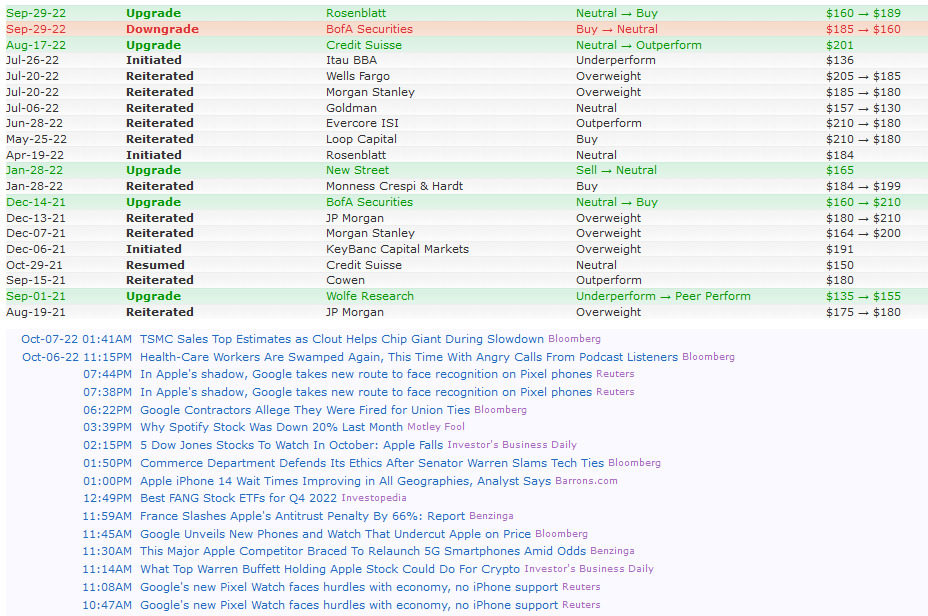

## 1. Import Libraries

In [2]:
!pip install yfinance

In [3]:
# libraries for webscraping, parsing and getting stock data
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import yfinance as yf

# for plotting and data manipulation
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import plotly.express as px

# NLTK VADER for sentiment analysis
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## List Down Tickers and Number of Shares in Portfolio

In [4]:
tickers_dict = {'AMD': 7, 
                'ASML': 6,
                'TSM': 6,
                'NEE': 7,
                'MSFT': 7,
                'MCD': 6,
                'AMZN': 7,
                'GOOGL': 7,
                'AAPL': 7,
                'NVDA': 7,
                'UNH': 6,
                'IRDM': 7,
                'TSLA': 6,
                'PLD': 7} 

In [5]:
tickers = tickers_dict.keys()
number_of_shares = tickers_dict.values()

## Scrape News Headlines and Perform Sentiment Analysis

In [6]:
# Scrape the Date, Time and News Headlines Data
finwiz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    print(ticker)
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

AMD
ASML
TSM
NEE
MSFT
MCD
AMZN
GOOGL
AAPL
NVDA
UNH
IRDM
TSLA
PLD


## Print the Data from news_table (optional)

In [7]:
# Print the Data from news_table (optional)
# Example: Read one single day of headlines for ‘AMZN’ 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into ‘amzn_tr’
amzn_tr = amzn.findAll('tr')
for i, table_row in enumerate(amzn_tr):
     # Read the text of the element ‘a’ into ‘link_text’
     a_text = table_row.a.text
     # Read the text of the element ‘td’ into ‘data_text’
     td_text = table_row.td.text
     # Print the contents of ‘link_text’ and ‘data_text’ 
     print(a_text)
     print(td_text)
     # Exit after printing 4 rows of data
     if i == 3:
         break

U.S. dollar rises, bitcoin sinks, Tesla and Amazon stocks under pressure
Oct-07-22 10:29AM
Your Streaming Services Have a New Way to Keep You Loyal: Theyre Teaming Up
10:01AM
DoorDash (DASH) Introduces Feature Drinks With DoubleDash
09:34AM
11 Best FAANG Stocks To Buy Now
09:24AM


## Parse the Date, Time and News Headlines into a Python List


In [8]:
# Parse the Date, Time and News Headlines into a Python List
parsed_news = []
# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        if x.a:
        # read the text from each tr tag into text
            # get text from a only
            text = x.a.get_text() 

            # splite text in the td tag into a list 
            date_scrape = x.td.text.split()
            # if the length of 'date_scrape' is 1, load 'time' as the only element
            if len(date_scrape) == 1:
                time = date_scrape[0]

            # else load 'date' as the 1st element and 'time' as the second    
            else:
                date = date_scrape[0]
                time = date_scrape[1]
            # Extract the ticker from the file name, get the string up to the 1st '_'  
            ticker = file_name.split('_')[0]

            # Append ticker, date, time and headline as a list to the 'parsed_news' list
            parsed_news.append([ticker, date, time, text])
        
parsed_news[:5] # print first 5 rows of news

[['AMD',
  'Oct-07-22',
  '11:15AM',
  'White House Adds New Restrictions on Chip Exports to China'],
 ['AMD',
  'Oct-07-22',
  '10:50AM',
  '[video]VIDEO: Breaking Down the Jobs Report'],
 ['AMD',
  'Oct-07-22',
  '10:41AM',
  "AMD Stock Is Hitting Lows. Here's When to Buy."],
 ['AMD', 'Oct-07-22', '10:30AM', 'Is AMD Stock a Buy Right Now?'],
 ['AMD',
  'Oct-07-22',
  '10:18AM',
  'US STOCKS-Wall Street slips as jobs growth boosts rate hike bets']]

## Perform Sentiment Analysis with Vader


In [9]:
# Perform Sentiment Analysis with Vader
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()
# Set column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()
# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')
# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date
parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMD,2022-10-07,11:15AM,White House Adds New Restrictions on Chip Expo...,0.000,1.000,0.000,0.0000
1,AMD,2022-10-07,10:50AM,[video]VIDEO: Breaking Down the Jobs Report,0.000,1.000,0.000,0.0000
2,AMD,2022-10-07,10:41AM,AMD Stock Is Hitting Lows. Here's When to Buy.,0.184,0.816,0.000,-0.2023
3,AMD,2022-10-07,10:30AM,Is AMD Stock a Buy Right Now?,0.000,1.000,0.000,0.0000
4,AMD,2022-10-07,10:18AM,US STOCKS-Wall Street slips as jobs growth boo...,0.000,0.647,0.353,0.5994


In [10]:
parsed_and_scored_news

,ticker,date,time,headline,neg,neu,pos,compound
0,AMD,2022-10-07,11:15AM,White House Adds New Restrictions on Chip Expo...,0.000,1.000,0.000,0.0000
1,AMD,2022-10-07,10:50AM,[video]VIDEO: Breaking Down the Jobs Report,0.000,1.000,0.000,0.0000
2,AMD,2022-10-07,10:41AM,AMD Stock Is Hitting Lows. Here's When to Buy.,0.184,0.816,0.000,-0.2023
3,AMD,2022-10-07,10:30AM,Is AMD Stock a Buy Right Now?,0.000,1.000,0.000,0.0000
4,AMD,2022-10-07,10:18AM,US STOCKS-Wall Street slips as jobs growth boo...,0.000,0.647,0.353,0.5994
...,...,...,...,...,...,...,...,...
1395,PLD,2022-07-28,01:06PM,"Duke Realty (DRE) Q2 FFO Beats Estimates, Reve...",0.167,0.833,0.000,-0.1531
1396,PLD,2022-07-28,08:00AM,Prologis Sets Meeting and Record Dates for Spe...,0.000,0.748,0.252,0.4019
1397,PLD,2022-07-28,05:48AM,Here's Why Prologis Sees Huge Rent Increases,0.000,0.723,0.277,0.3182
1398,PLD,2022-07-27,05:31PM,"Exclusive: Robbed at gunpoint, prominent Bay A...",0.000,0.625,0.375,0.7506


## Calculate Mean Sentiment for Each Ticker

In [11]:
# Group by each ticker and get the mean of all sentiment scores
mean_scores = parsed_and_scored_news.groupby(['ticker']).mean()
mean_scores

,neg,neu,pos,compound
ticker,,,,
AAPL,0.05576,0.85131,0.09291,0.060275
AMD,0.07747,0.80658,0.11595,0.071762
AMZN,0.05129,0.76720,0.18153,0.184195
ASML,0.07257,0.80599,0.12142,0.078599
GOOGL,0.04858,0.84357,0.10783,0.093379
IRDM,0.01267,0.87758,0.10976,0.169490
MCD,0.07851,0.80117,0.12032,0.062719
MSFT,0.04649,0.84759,0.10592,0.100352
NEE,0.01832,0.74947,0.23222,0.323312


## Get Current Price, Sector and Industry of each Ticker

In [12]:
sectors = []
industries = []
prices = []
for ticker in tickers:
    print(ticker)
    tickerdata = yf.Ticker(ticker)
    prices.append(tickerdata.info['regularMarketPrice'])
    sectors.append(tickerdata.info['sector'])
    industries.append(tickerdata.info['industry'])

AMD
ASML
TSM
NEE
MSFT
MCD
AMZN
GOOGL
AAPL
NVDA
UNH
IRDM
TSLA
PLD


In [13]:
sectors

['Technology',
 'Technology',
 'Technology',
 'Utilities',
 'Technology',
 'Consumer Cyclical',
 'Consumer Cyclical',
 'Communication Services',
 'Technology',
 'Technology',
 'Healthcare',
 'Communication Services',
 'Consumer Cyclical',
 'Real Estate']

In [14]:
industries

['Semiconductors',
 'Semiconductor Equipment & Materials',
 'Semiconductors',
 'Utilities—Regulated Electric',
 'Software—Infrastructure',
 'Restaurants',
 'Internet Retail',
 'Internet Content & Information',
 'Consumer Electronics',
 'Semiconductors',
 'Healthcare Plans',
 'Telecom Services',
 'Auto Manufacturers',
 'REIT—Industrial']

## Combine the Information Above and the Corresponding Tickers into a DataFrame

In [15]:
# dictionary {'column name': list of values for column} to be converted to dataframe
d = {'Sector': sectors, 'Industry': industries, 'Price': prices, 'No. of Shares': number_of_shares}
# create dataframe from 
df_info = pd.DataFrame(data=d, index = tickers)
df_info

,Sector,Industry,Price,No. of Shares
AMD,Technology,Semiconductors,60.6250,7
ASML,Technology,Semiconductor Equipment & Materials,437.6800,6
TSM,Technology,Semiconductors,70.6100,6
NEE,Utilities,Utilities—Regulated Electric,77.4100,7
MSFT,Technology,Software—Infrastructure,235.7300,7
MCD,Consumer Cyclical,Restaurants,233.9650,6
AMZN,Consumer Cyclical,Internet Retail,115.1602,7
GOOGL,Communication Services,Internet Content & Information,99.2000,7
AAPL,Technology,Consumer Electronics,140.9500,7
NVDA,Technology,Semiconductors,122.6116,7


## Calculate the Total Value of Each Ticker in the Portfolio

In [16]:
df_info['Total Stock Value in Portfolio'] = df_info['Price']*df_info['No. of Shares']
df_info

,Sector,Industry,Price,No. of Shares,Total Stock Value in Portfolio
AMD,Technology,Semiconductors,60.6250,7,424.3750
ASML,Technology,Semiconductor Equipment & Materials,437.6800,6,2626.0800
TSM,Technology,Semiconductors,70.6100,6,423.6600
NEE,Utilities,Utilities—Regulated Electric,77.4100,7,541.8700
MSFT,Technology,Software—Infrastructure,235.7300,7,1650.1100
MCD,Consumer Cyclical,Restaurants,233.9650,6,1403.7900
AMZN,Consumer Cyclical,Internet Retail,115.1602,7,806.1214
GOOGL,Communication Services,Internet Content & Information,99.2000,7,694.4000
AAPL,Technology,Consumer Electronics,140.9500,7,986.6500
NVDA,Technology,Semiconductors,122.6116,7,858.2812


## Join all the Information into a Single DataFrame


In [17]:
df = mean_scores.join(df_info)
df = df.rename(columns={"compound": "Sentiment Score", "neg": "Negative", "neu": "Neutral", "pos": "Positive"})
df = df.reset_index()
df

,ticker,Negative,Neutral,Positive,Sentiment Score,Sector,Industry,Price,No. of Shares,Total Stock Value in Portfolio
0,AAPL,0.05576,0.85131,0.09291,0.060275,Technology,Consumer Electronics,140.9500,7,986.6500
1,AMD,0.07747,0.80658,0.11595,0.071762,Technology,Semiconductors,60.6250,7,424.3750
2,AMZN,0.05129,0.76720,0.18153,0.184195,Consumer Cyclical,Internet Retail,115.1602,7,806.1214
3,ASML,0.07257,0.80599,0.12142,0.078599,Technology,Semiconductor Equipment & Materials,437.6800,6,2626.0800
4,GOOGL,0.04858,0.84357,0.10783,0.093379,Communication Services,Internet Content & Information,99.2000,7,694.4000
5,IRDM,0.01267,0.87758,0.10976,0.169490,Communication Services,Telecom Services,47.5400,7,332.7800
6,MCD,0.07851,0.80117,0.12032,0.062719,Consumer Cyclical,Restaurants,233.9650,6,1403.7900
7,MSFT,0.04649,0.84759,0.10592,0.100352,Technology,Software—Infrastructure,235.7300,7,1650.1100
8,NEE,0.01832,0.74947,0.23222,0.323312,Utilities,Utilities—Regulated Electric,77.4100,7,541.8700
9,NVDA,0.05014,0.84808,0.10178,0.102890,Technology,Semiconductors,122.6116,7,858.2812


## Generate the Treemap Plot!

In [18]:
fig = px.treemap(df, path=[px.Constant("Sectors"), 'Sector', 'Industry', 'ticker'], values='Total Stock Value in Portfolio',
                  color='Sentiment Score', hover_data=['Price', 'Negative', 'Neutral', 'Positive', 'Sentiment Score'],
                  color_continuous_scale=['#FF0000', "#000000", '#00FF00'],
                  color_continuous_midpoint=0)

fig.data[0].customdata = df[['Price', 'Negative', 'Neutral', 'Positive', 'Sentiment Score']].round(3) # round to 3 decimal places
fig.data[0].texttemplate = "%{label}<br>%{customdata[4]}"

fig.update_traces(textposition="middle center")
fig.update_layout(margin = dict(t=30, l=10, r=10, b=10), font_size=20)

plotly.offline.plot(fig, filename='stock_sentiment.html') # this writes the plot into a html file and opens it
fig.show()